In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import glob 
from numpy.linalg import eig
import seaborn as sns
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
sns.set()
%matplotlib inline

In [81]:
#Get adjusting closing prices from each {sector}.csv file

df = pd.concat([pd.read_csv(f, usecols=[0,5], index_col = [0]) for f in glob.glob('*.csv')], ignore_index = True, axis = 1)

In [65]:
#Change column names to sector names
labels = [ f[0:3] for f in glob.glob('*.csv') ]
df.columns = labels


#Create dictionary mapping tickers to names


In [86]:
ret = df.pct_change().dropna()
ret.head()


,0,1,2,3,4,5,6,7,8
Date,,,,,,,,,
1998-12-23,0.010504,0.020820,0.014743,0.017452,0.023893,0.024174,-0.004191,0.022472,0.004294
1998-12-24,0.023014,-0.005263,0.006607,0.013193,-0.003810,-0.001727,0.018412,0.006107,0.018327
1998-12-28,-0.008709,-0.005291,-0.013123,0.005208,0.002867,-0.005767,-0.005167,-0.014563,-0.008999
1998-12-29,0.018302,0.009973,0.010638,0.014247,0.002861,0.022042,0.016615,0.022167,0.021792
1998-12-30,-0.002876,-0.015142,-0.003949,-0.004471,-0.003802,-0.006243,-0.008172,-0.008436,-0.008294


<BarContainer object of 9 artists>

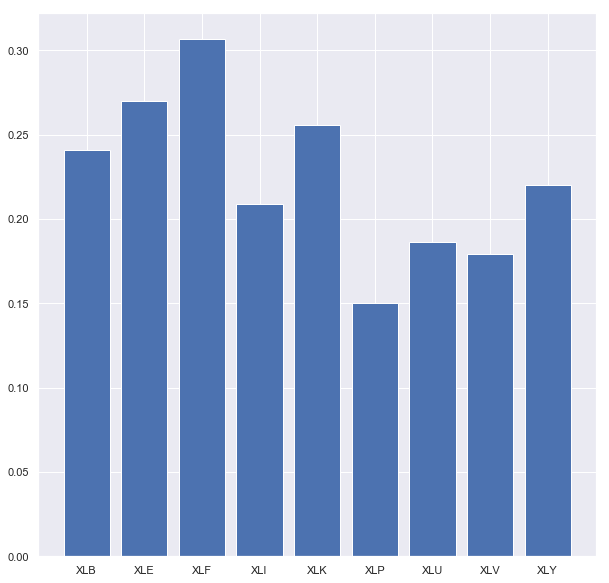

In [67]:
#Should you normalize this data? We'll come back to this...
volatility = ret.std()*np.sqrt(252)
plt.figure(figsize =(10,10))
plt.bar(volatility.index, volatility)


In [68]:
## Get Eigenvectors and Eigenvalues
eig_val, eig_vec = eig(ret.cov())


Text(0.5,1,'Cumalative Explained Variance')

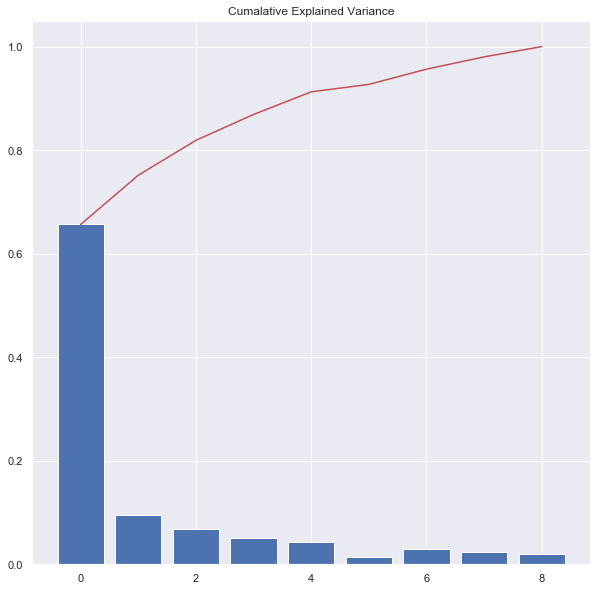

In [72]:
## Plot eigen values (percentage of explained variance) and the cumulative explained variance

x = list(range(len(eig_val)))
y = [x / sum(eig_val) for x in eig_val]

plt.figure(figsize =(10,10))
plt.bar(x, y)
plt.plot(np.cumsum(y), color = 'r')
plt.title("Cumalative Explained Variance")

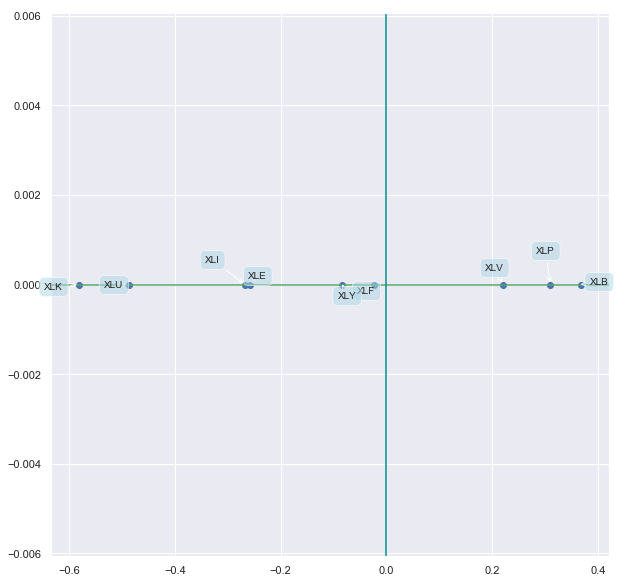

In [71]:
#project eigenvectors in 1-d
y1 = eig_vec[0,:]

plt.figure(figsize =(10,10))
plt.scatter(y1, [0]*9, marker = 'o')
plt.axhline(y = 0, color = 'g')
plt.axvline(x = 0, color = 'darkcyan')

for label, x_, y_ in zip(labels, y1, [0]*9):
    plt.annotate(
        label,
        xy=(x_, y_), xytext=(np.random.randint(low =-30, high =30), np.random.randint(low =-30, high =30)),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

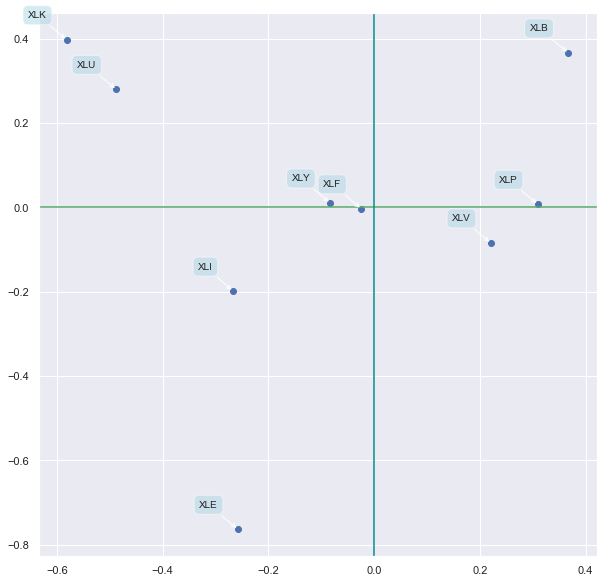

In [69]:
#project eigenvectors in 2-d
y1 = eig_vec[0,:]
y2 = eig_vec[1,:]

plt.figure(figsize =(10,10))
plt.scatter(y1, y2, marker = 'o')
plt.axhline(y = 0, color = 'g')
plt.axvline(x = 0, color = 'darkcyan')

for label, x_, y_ in zip(labels, y1, y2):
    plt.annotate(
        label,
        xy=(x_, y_), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

In [93]:
## Interactive covariance
def eig_vec_calc(returns, window, start = 0):
    eig_val, _ = eig(returns.iloc[start:start+window,:].cov())
    x = list(range(len(eig_val)))
    y = [x / sum(eig_val) for x in eig_val]
    plt.figure(figsize =(10,10))
    plt.bar(x, y)
    plt.title('Date: {} - {}'.format(returns.index[start], returns.index[start+window]))

In [97]:
interact(eig_vec_calc, returns = fixed(ret), window = (30,300,10), start = (0,4800,100))

interactive(children=(IntSlider(value=160, description='window', max=300, min=30, step=10), IntSlider(value=0,…

<function __main__.eig_vec_calc(returns, window, start=0)>

In [99]:
#idx = np.argsort(evals)[::-1]
#evecs = evecs[:,idx]
#evals = evals[idx]|

In [100]:
cov = ret.cov()
cov

,0,1,2,3,4,5,6,7,8
0,0.000230,0.000178,0.000187,0.000159,0.000139,0.000077,0.000088,0.000101,0.000147
1,0.000178,0.000290,0.000175,0.000141,0.000126,0.000074,0.000104,0.000093,0.000126
2,0.000187,0.000175,0.000374,0.000188,0.000188,0.000100,0.000106,0.000129,0.000196
3,0.000159,0.000141,0.000188,0.000173,0.000153,0.000076,0.000082,0.000105,0.000148
4,0.000139,0.000126,0.000188,0.000153,0.000259,0.000067,0.000082,0.000118,0.000154
5,0.000077,0.000074,0.000100,0.000076,0.000067,0.000089,0.000060,0.000061,0.000080
6,0.000088,0.000104,0.000106,0.000082,0.000082,0.000060,0.000138,0.000065,0.000079
7,0.000101,0.000093,0.000129,0.000105,0.000118,0.000061,0.000065,0.000127,0.000107
8,0.000147,0.000126,0.000196,0.000148,0.000154,0.000080,0.000079,0.000107,0.000192


In [108]:
w = np.random.randn(9)
np.dot(w.T,cov)

array([-0.00050054, -0.00051577, -0.000409  , -0.00045167, -0.00051038,
       -0.00021547, -0.00033186, -0.00032902, -0.0004169 ])